Adrian-Nichita Zloteanu  
MSCS-634  
Lab 3 – K-Means vs K-Medoids on the Wine Dataset

First, I will load the dataset, and print the features & class distribution.
Next I'll standardize the data to ensure consistent scaling.

In [16]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

wine = load_wine()
X = wine.data
y = wine.target

print("Feature names:", wine.feature_names)
print("Target names:", wine.target_names)

# create a DataFrame
df = pd.DataFrame(X, columns=wine.feature_names)
df['target'] = y
print(df.head())

# print class distribution
classes, counts = np.unique(y, return_counts=True)
for cls, count in zip(classes, counts):
    print(f"class {cls}: {count} samples")

# standardize using z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                

Now I'll implement KMeans clustering with k=3, since there are 3 wine classes. I will print silhouette score and ARI.

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Metrics
kmeans_silhouette = silhouette_score(X_scaled, labels) # using the z-score normalized data for silhouette
kmeans_ari = adjusted_rand_score(y, labels) # using the original labels for ARI

print(f"Silhouette Score: {kmeans_silhouette}")
print(f"ARI: {kmeans_ari}")

Silhouette Score: 0.2848589191898987
ARI: 0.8974949815093207


Next, I'll do K-Medoids clustering with k=3. I'll use the same metrics to compare.

In [23]:
# Could not use sklearn_extra KMedoids due to macOS support issues; using pyclustering instead
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

# randomly select initial medoids
np.random.seed(1)
initial_medoids = np.random.choice(range(len(X_scaled)), size=3, replace=False)

# create K-Medoids instance
kmedoids_instance = kmedoids(X_scaled.tolist(), initial_medoids.tolist(), data_type='points')
kmedoids_instance.process()
kmedoids_labels = np.zeros(len(X_scaled), dtype=int)
for idx, cluster in enumerate(kmedoids_instance.get_clusters()):
    kmedoids_labels[cluster] = idx

# metrics
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)

print(f"K-Medoids Silhouette Score: {kmedoids_silhouette}")
print(f"K-Medoids ARI: {kmedoids_ari}")

K-Medoids Silhouette Score: 0.2676220575785755
K-Medoids ARI: 0.7411365432162113


Now I will create side-by-side scatter plots for both algorithms, marking the centroits / medoids for clarity.

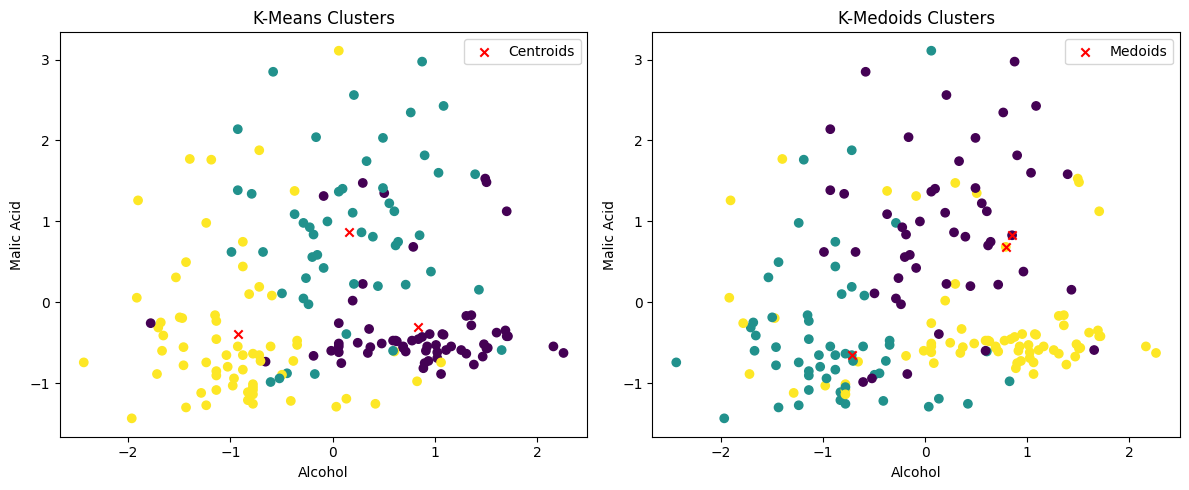

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# K-Means plot
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels)
axs[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', label='Centroids')
axs[0].set_title('K-Means Clusters')
axs[0].set_xlabel('Alcohol')
axs[0].set_ylabel('Malic Acid')
axs[0].legend()

# K-Medoids plot
axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmedoids_labels)
axs[1].scatter(X_scaled[initial_medoids, 0], X_scaled[initial_medoids, 1], c='red', marker='x', label='Medoids')
axs[1].set_title('K-Medoids Clusters')
axs[1].set_xlabel('Alcohol')
axs[1].set_ylabel('Malic Acid')
axs[1].legend()

plt.tight_layout()
plt.show()

Result analysis

After trying both algorithms, I think K-Medoids gave clearer clusters. The medoids are real data points, so the groups look more natural and better defined. K-Means was messier — some centroids ended up in spots with no actual data, and the clusters looked more spread out.

K-Means is definitely faster and might work better when the data is nicely shaped, but in this case, the clusters weren’t clean enough. K-Medoids felt more stable and made more sense for this kind of uneven data. This showed me that the choice of algorithm can really change how the results look.

